# Regression with PyTorch

## Data generation
The **exact** function is $$ f(x) = tanh \big( a \, x^5 + b \, cos(\omega x) \big)$$
but we add a gaussian white noise, so we get $$y = f(x) + \epsilon$$ with $$\epsilon \sim \mathcal{N}(0,\sigma^2)$$

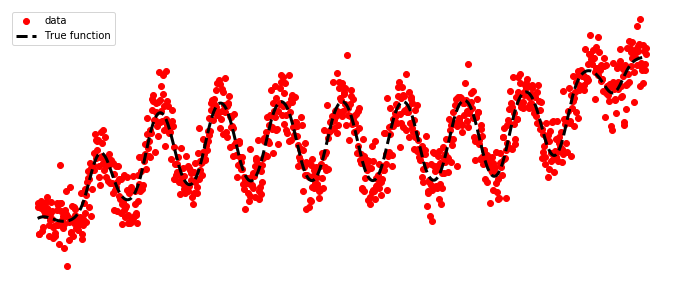

In [222]:
import torch
import math
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

h = 0.002
var = 0.2
omega = 10*math.pi
eps = 0.5
x = torch.arange(-1,1,h).view((-1,1))
y_true = (2*torch.pow(x,5)+eps*torch.cos(omega*x)).view((-1,1))
y_true = torch.tanh(y_true)
y = y_true + var*torch.randn(x.size())
plt.figure(figsize=(12,5))
plt.axis('off')
plt.plot(x,y,'ro', label ='data')
plt.plot(x,y_true,'k--',linewidth='3', label='True function')
plt.legend()

The black curve represent the exact funtion f, and the red points stand for the data (x, y)

## Data spliting
We split the data such that 70% will be devoted to the training process, and 30% for the validation

In [223]:
from sklearn.model_selection import train_test_split

ratio = 0.3

x_train, x_test, y_train, y_test  = train_test_split(x.numpy(), y.numpy(), test_size=ratio)

x_train = torch.from_numpy(x_train)
x_test = torch.from_numpy(x_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

n = x_train.shape[0]

print('Training set size :', n)

Training set size : 700


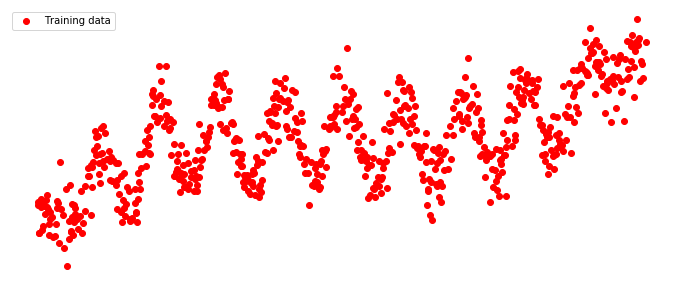

In [292]:
plt.figure(figsize=(12,5))
plt.axis('off')
plt.plot(x_train,y_train,'ro', label ='Training data')
plt.legend()

## Linear regression

We first try to learn the function f by using a linear regression.

In [224]:
from torch import nn

class LinearNeuralNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.lin = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.lin(x)

In [225]:
from torch import optim
import torch.nn.functional as F

input_dim = x.shape[1]
output_dim = y.shape[1]

lr = 1e-3
bs = n
epochs = 1000

model = LinearNeuralNetwork(input_dim, output_dim)
loss_func = F.mse_loss
opt = optim.Adam(model.parameters(), lr=lr)

In [226]:
for epoch in range(epochs):
    pred = model(x_train)
    loss = loss_func(pred, y_train)
    loss.backward()
    opt.step()
    opt.zero_grad()
    if epoch%100 == 0:
        print('epoch', epoch, '/ loss =', loss.item())

epoch 0 / loss = 0.9388026595115662
epoch 100 / loss = 0.7626340389251709
epoch 200 / loss = 0.6212847828865051
epoch 300 / loss = 0.5099629163742065
epoch 400 / loss = 0.4237096309661865
epoch 500 / loss = 0.35789191722869873
epoch 600 / loss = 0.30831921100616455
epoch 700 / loss = 0.2713439166545868
epoch 800 / loss = 0.24392756819725037
epoch 900 / loss = 0.22364994883537292


In [227]:
train_loss = loss_func(model(x_train), y_train).item()
val_loss = loss_func(model(x_test), y_test).item()
true_loss = loss_func(model(x), y_true).item()

print('Training set loss =', train_loss)
print('Test set loss =', val_loss)
print('True loss =', true_loss)

df = pd.DataFrame(index=['Training_Loss','Validation_Loss','True_Loss'])
df['LinearRegression'] = [train_loss, val_loss, true_loss]

Training set loss = 0.208662211894989
Test set loss = 0.21731869876384735
True loss = 0.16413083672523499


In [228]:
y_pred = model(x).detach().numpy()

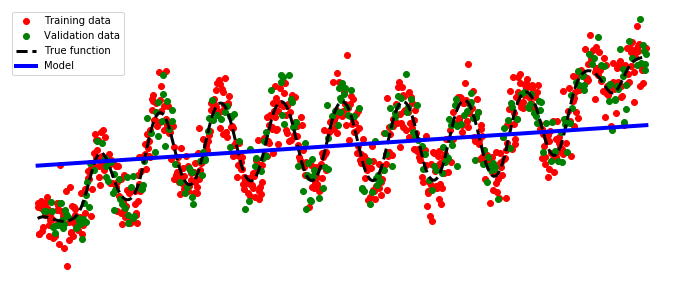

In [229]:
plt.figure(figsize=(12,5))
plt.axis('off')
plt.plot(x_train,y_train,'ro', label='Training data')
plt.plot(x_test,y_test,'go', label='Validation data')
plt.plot(x,y_true,'k--',linewidth='3', label='True function')
plt.plot(x,y_pred,'b-',linewidth='4', label='Model')
plt.legend()

The red points stand for the training data, whereas the green points stand for the validation data.
The function learnt by using the linear regression is depicted in blue.

As we can see, we have a high bias.
The model is not enough complex.

## Polynomial regression

A way to adapt our linear regression to more complex functions, is by extended the input features.
Here we try to learn the function f by using the following model: $$\hat{y} = \sum\limits_{d=0}^D \alpha_d x^d$$
and where the coefficients $$\alpha_d$$ will be learnt.

In [244]:
D = 20

x_train_new = torch.empty((n,D))
x_test_new = torch.empty((x_test.shape[0],D))
x_new = torch.empty((x.shape[0],D))

for d in range(D):
    x_train_new[:,d] = torch.pow(x_train.view(-1),d+1)
    x_test_new[:,d] = torch.pow(x_test.view(-1),d+1)
    x_new[:,d] = torch.pow(x.view(-1),d+1)

In [245]:
lr = 1e-1
bs = n
epochs = 10000

model_poly = LinearNeuralNetwork(D, output_dim)
loss_func = F.mse_loss
opt = optim.Adam(model_poly.parameters(), lr=lr)

In [246]:
for epoch in range(epochs):
    pred = model_poly(x_train_new)
    loss = loss_func(pred, y_train)
    loss.backward()
    opt.step()
    opt.zero_grad()
    if epoch%1000 == 0:
        print('epoch', epoch, '/ loss =', loss.item())

epoch 0 / loss = 0.24146731197834015
epoch 1000 / loss = 0.13326790928840637
epoch 2000 / loss = 0.1331879198551178
epoch 3000 / loss = 0.1331416666507721
epoch 4000 / loss = 0.13311249017715454
epoch 5000 / loss = 0.13390742242336273
epoch 6000 / loss = 0.13308730721473694
epoch 7000 / loss = 0.1330575793981552
epoch 8000 / loss = 0.1330433040857315
epoch 9000 / loss = 0.13303004205226898


In [247]:
train_loss = loss_func(model_poly(x_train_new), y_train).item()
val_loss = loss_func(model_poly(x_test_new), y_test).item()
true_loss = loss_func(model_poly(x_new), y_true).item()

print('Training set loss =', train_loss)
print('Test set loss =', val_loss)
print('True loss =', true_loss)

df['PolynomialRegression'] = [train_loss, val_loss, true_loss]

Training set loss = 0.13301758468151093
Test set loss = 0.12960295379161835
True loss = 0.08775435388088226


In [248]:
y_pred = model_poly(x_new).detach().numpy()

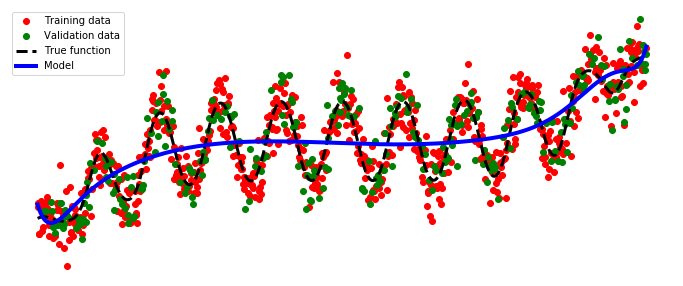

In [249]:
plt.figure(figsize=(12,5))
plt.axis('off')
plt.plot(x_train,y_train,'ro', label='Training data')
plt.plot(x_test,y_test,'go', label='Validation data')
plt.plot(x,y_true,'k--',linewidth='3', label='True function')
plt.plot(x,y_pred,'b-',linewidth='4', label='Model')
plt.legend()

Even if the result is better, we still have a high bias.

To handle this issue, we will use a deep neural network.

## Deep Neural Network
Consider now a deep neural network compose of three hidden layers.

In [236]:
class DeepNeuralNetwork(nn.Module):
    
    def __init__(self, input_dim, hidden_1_dim, hidden_2_dim, hidden_3_dim, output_dim):
        super().__init__()
        self.hidden_1 = torch.nn.Linear(input_dim, hidden_1_dim)   # hidden layer
        self.hidden_2 = torch.nn.Linear(hidden_1_dim, hidden_2_dim)   # hidden layer
        self.hidden_3 = torch.nn.Linear(hidden_2_dim, hidden_3_dim)   # hidden layer
        self.predict = torch.nn.Linear(hidden_3_dim, output_dim)   # output layer

    def forward(self, x):
        x = self.hidden_1(x)
        x = F.relu(x)
        x = self.hidden_2(x)
        x = F.relu(x)
        x = self.hidden_3(x)
        x = F.relu(x)
        return self.predict(x)
    

In [237]:
input_dim = x.shape[1]
hidden_1_dim = 100
hidden_2_dim = 100
hidden_3_dim = 100
output_dim = y.shape[1]

lr = 1e-3
bs = n
epochs = 10000

model_2 = DeepNeuralNetwork(input_dim, hidden_1_dim, hidden_2_dim, hidden_3_dim, output_dim)
loss_func = F.mse_loss
opt = optim.Adam(model_2.parameters(), lr=lr)

In [238]:
loss_train = []
loss_test = []
for epoch in range(epochs):
    pred = model_2(x_train)
    loss = loss_func(pred, y_train)
    loss.backward()
    opt.step()
    opt.zero_grad()
    loss_train.append(loss_func(model_2(x_train), y_train).item())
    loss_test.append(loss_func(model_2(x_test), y_test).item())
    if epoch%1000 == 0:
        print('epoch', epoch, '/ loss =', loss.item())

epoch 0 / loss = 0.27112463116645813
epoch 1000 / loss = 0.09602297842502594
epoch 2000 / loss = 0.07858290523290634
epoch 3000 / loss = 0.061713144183158875
epoch 4000 / loss = 0.048569127917289734
epoch 5000 / loss = 0.0424208827316761
epoch 6000 / loss = 0.04515405371785164
epoch 7000 / loss = 0.061105214059352875
epoch 8000 / loss = 0.038648609071969986
epoch 9000 / loss = 0.0445253923535347


In [239]:
train_loss = loss_func(model_2(x_train), y_train).item()
val_loss = loss_func(model_2(x_test), y_test).item()
true_loss = loss_func(model_2(x), y_true).item()

print('Training set loss =', train_loss)
print('Test set loss =', val_loss)
print('True loss =', true_loss)
df['DeepNeuralNetwork'] = [train_loss, val_loss, true_loss]

Training set loss = 0.037913449108600616
Test set loss = 0.04471955448389053
True loss = 0.005029006395488977


In [240]:
y_pred = model_2(x).detach().numpy()

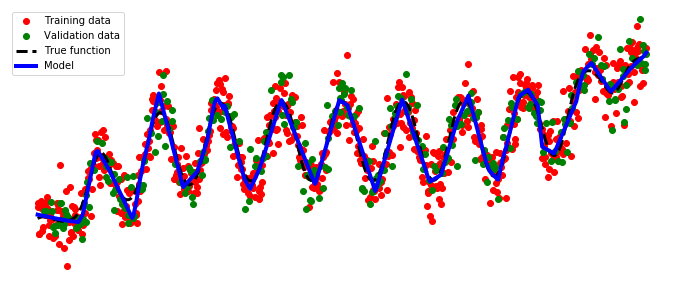

In [243]:
plt.figure(figsize=(12,5))
plt.axis('off')
plt.plot(x_train,y_train,'ro', label='Training data')
plt.plot(x_test,y_test,'go', label='Validation data')
plt.plot(x,y_true,'k--',linewidth='3', label='True function')
plt.plot(x,y_pred,'b-',linewidth='4', label='Model')
plt.legend()

The deep neural network is able to learn the complexity provided by the fuction f.

Moreover, there is no overfitting.
It is shown on the graphic above, where the loss during epoch evolution in depicted for the training set (in black), and for the validation set (in red).
We can see that the two loss are decreasing.

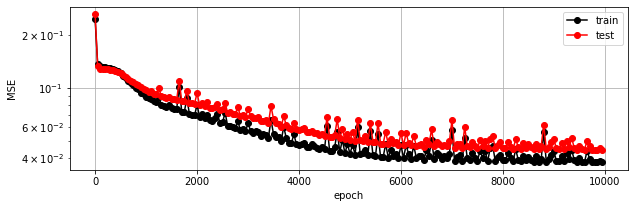

In [242]:
plt.figure(figsize=(10,3))
plt.plot(range(epochs)[::50], loss_train[::50],'ko-', label = 'train')
plt.plot(range(epochs)[::50], loss_test[::50],'ro-', label = 'test')
plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.grid()
plt.legend(loc='best')

Let us now compare the performance of the deep neural network with support machine vectors, which are powerfull 
ML algorihtms.

## SVM with rbf kernel
We first consider the classical radial basis function kernel.
Hence, we assume that the function f si smooth.

In [251]:
from sklearn.svm import SVR

clf = SVR(C=1.0, kernel='rbf')
clf.fit(x_train, y_train.reshape(-1,))

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [252]:
train_loss = loss_func(torch.from_numpy(clf.predict(x_train)).view(-1,1), y_train).item()
val_loss = loss_func(torch.from_numpy(clf.predict(x_test)).view(-1,1), y_test).item()
true_loss = loss_func(torch.from_numpy(clf.predict(x)).view(-1,1), y_true).item()

print('Training set loss =', train_loss)
print('Test set loss =', val_loss)
print('True loss =', true_loss)
df['SVM_rbf'] = [train_loss, val_loss, true_loss]

Training set loss = 0.13455546292781023
Test set loss = 0.13112396307541496
True loss = 0.08974648147162663


In [253]:
y_pred = clf.predict(x)

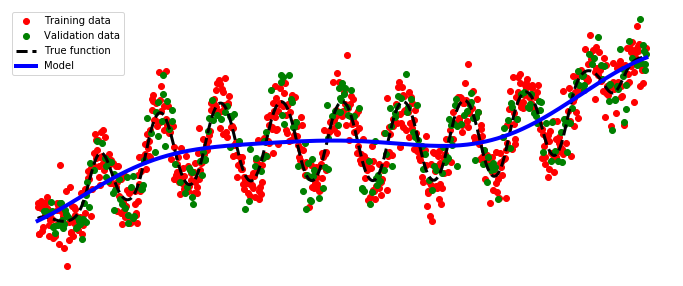

In [254]:
plt.figure(figsize=(12,5))
plt.axis('off')
plt.plot(x_train,y_train,'ro', label='Training data')
plt.plot(x_test,y_test,'go', label='Validation data')
plt.plot(x,y_true,'k--',linewidth='3', label='True function')
plt.plot(x,y_pred,'b-',linewidth='4', label='Model')
plt.legend()

The assumption on the smoothness of f was incorrect, and the model learnt is not well-fitting to the data.

We then choose an other kernel.

## SVM with Matérn kernel (less smooth approximation)

Matérn kernel are a generalization of rbf kernel, but where a parameter $\nu$ allow to choose the good smoothness

In [265]:
from sklearn.gaussian_process.kernels import Matern

kernel =  Matern(nu=0.35)

clf = SVR(C=1.0, kernel=kernel)
clf.fit(x_train, y_train.reshape(-1,))

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel=Matern(length_scale=1, nu=0.35), max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [266]:
train_loss = loss_func(torch.from_numpy(clf.predict(x_train)).view(-1,1), y_train).item()
val_loss = loss_func(torch.from_numpy(clf.predict(x_test)).view(-1,1), y_test).item()
true_loss = loss_func(torch.from_numpy(clf.predict(x)).view(-1,1), y_true).item()

print('Training set loss =', train_loss)
print('Test set loss =', val_loss)
print('True loss =', true_loss)
df['SVM_matern'] = [train_loss, val_loss, true_loss]

Training set loss = 0.03527734171080868
Test set loss = 0.04606030129931892
True loss = 0.005467394826543886


In [267]:
y_pred = clf.predict(x)

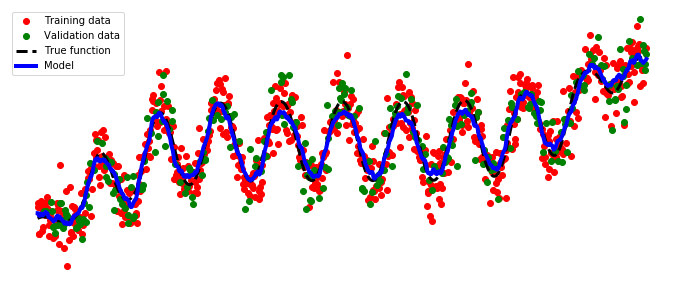

In [268]:
plt.figure(figsize=(12,5))
plt.axis('off')
plt.plot(x_train,y_train,'ro', label='Training data')
plt.plot(x_test,y_test,'go', label='Validation data')
plt.plot(x,y_true,'k--',linewidth='3', label='True function')
plt.plot(x,y_pred,'b-',linewidth='4', label='Model')
plt.legend()

## Summary

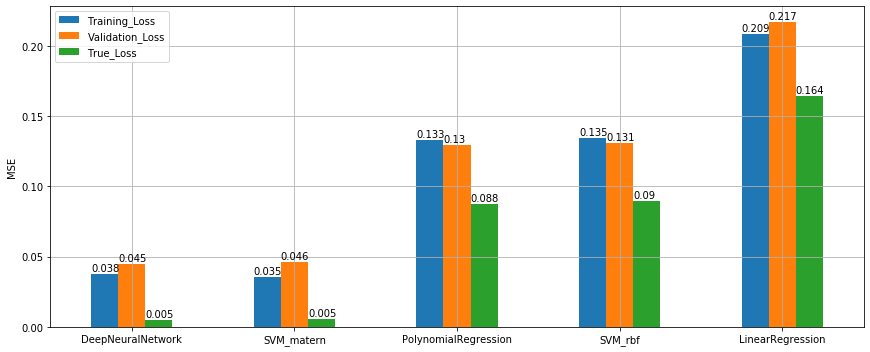

In [290]:
ax = df.T.sort_values(by='True_Loss',ascending=True).plot(kind='bar',figsize=(12,5),rot=0)
for p in ax.patches:
    ax.annotate(round(p.get_height(),3), (p.get_x(), p.get_height()+0.002))
plt.tight_layout()
plt.ylabel('MSE')
plt.grid()

In [291]:
df.T.sort_values(by='True_Loss',ascending=True)

,Training_Loss,Validation_Loss,True_Loss
DeepNeuralNetwork,0.037913,0.044720,0.005029
SVM_matern,0.035277,0.046060,0.005467
PolynomialRegression,0.133018,0.129603,0.087754
SVM_rbf,0.134555,0.131124,0.089746
LinearRegression,0.208662,0.217319,0.164131


# Conclusion

Deep Neural Networks allow to learn complex function with the accuracy of best-fitted ML algorithms and
without the need of hand-engeneering.